# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("local[*]")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-10m/

Found 8 items
-rw-r--r--   1 root supergroup      11563 2020-02-04 22:07 data/ml-10m/README.html
-rw-r--r--   1 root supergroup        753 2020-02-04 22:07 data/ml-10m/allbut.pl
-rw-r--r--   1 root supergroup    1368578 2020-02-04 22:07 data/ml-10m/links.csv
-rw-r--r--   1 root supergroup     500856 2020-02-04 22:07 data/ml-10m/movies.csv
-rw-r--r--   1 root supergroup  235105505 2020-02-04 22:07 data/ml-10m/ratings.csv
-rw-r--r--   1 root supergroup       1304 2020-02-04 22:07 data/ml-10m/split_ratings.sh
-rw-r--r--   1 root supergroup    3297408 2020-02-04 22:07 data/ml-10m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 22:07 data/ml-10m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-10m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,122,5,838985046',
 '1,185,5,838983525',
 '1,231,5,838983392',
 '1,292,5,838983421']

In [8]:
ratings.getNumPartitions()

2

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

10000054

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 27.6 ms, sys: 7.59 ms, total: 35.2 ms
Wall time: 39.9 s


69878

Сохраним датасет в память

In [10]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 1min 1s


69878

Количество фильмов

In [14]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

10677

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [17]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [18]:
movies_no_genre = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))
movies_no_genre.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [114]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])
movie_avg_rating.take(5)

[(2, 3.208070146276596),
 (4, 2.860544217687075),
 (40966, 3.0408653846153846),
 (8, 3.131256952169077),
 (51884, 3.7896039603960396)]

In [79]:
movie_avg_rating \
    .join(movies_no_genre) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

KeyboardInterrupt: 

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [ ]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [ ]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [14]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '15,4973,excellent!,1215184630',
 '20,1747,politics,1188263867',
 '20,1747,satire,1188263867',
 '20,2424,chick flick 212,1188263835']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

16529

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

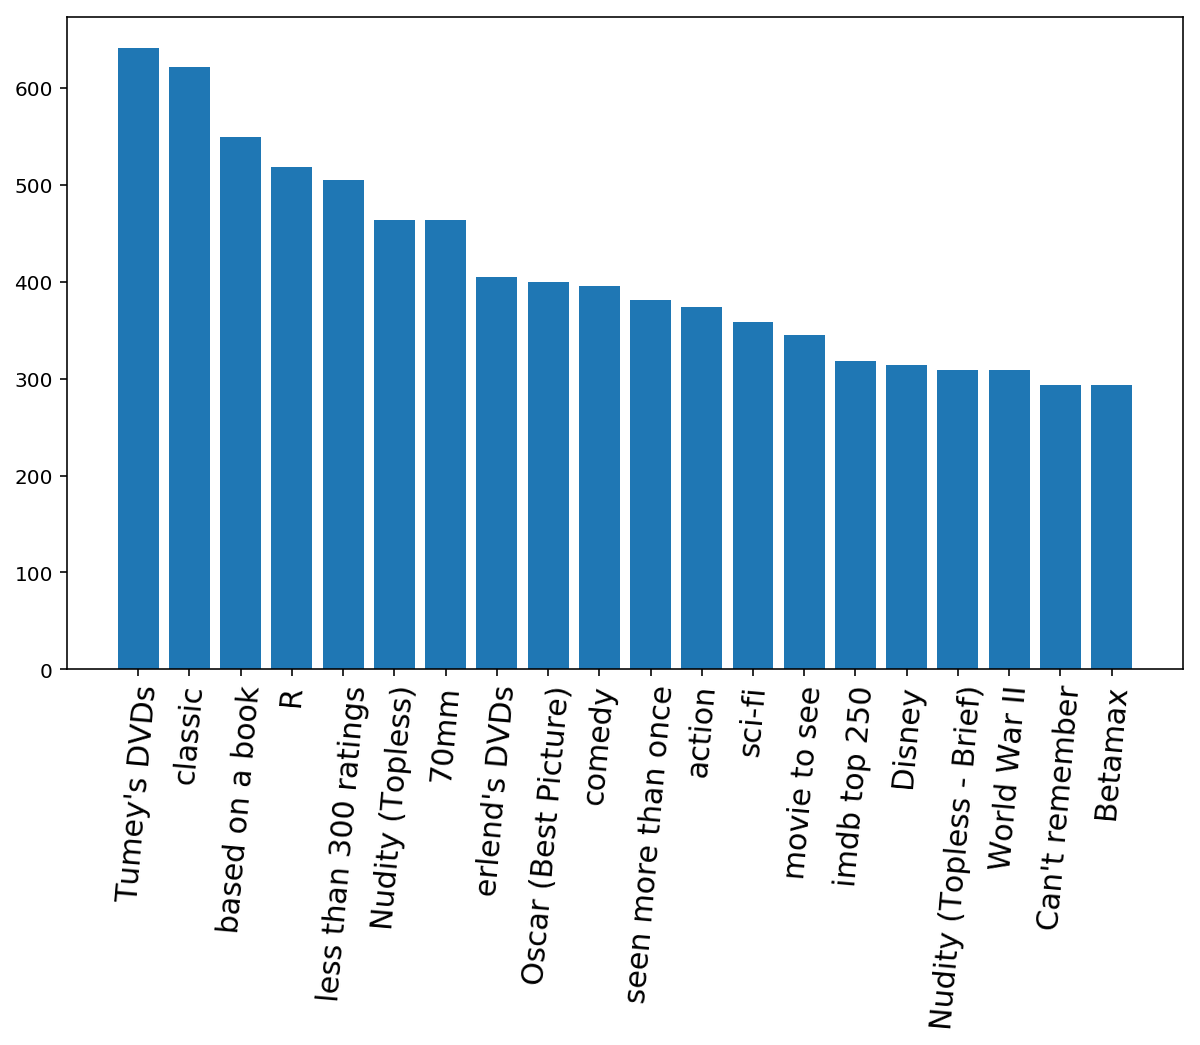

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [11]:
movie_ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)
movie_ratings_count.take(5)

[(2, 12032), (4, 1764), (40966, 208), (8, 899), (51884, 202)]

In [16]:
movie_ratings_count \
    .join(movies_no_genre) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

KeyboardInterrupt: 

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [17]:
movie_fives_count = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)
movie_fives_count.take(5)

[(2, 944), (4, 116), (6, 2964), (8, 74), (51884, 15)]

In [ ]:
movie_fives_count \
    .join(movies_no_genre) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [42]:
avg_ratings = movie_avg_rating \
    .map(lambda key_value: (round(key_value[1], 1), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
avg_ratings[:5]

[(0.5, 3), (0.8, 2), (2.9, 503), (4.6, 1), (4.1, 171)]

In [63]:
avg_ratings = sorted(avg_ratings, key=lambda count: count[1], reverse=True)
avg_ratings[:5]

[(3.5, 809), (3.4, 763), (3.2, 761), (3.6, 758), (3.3, 743)]

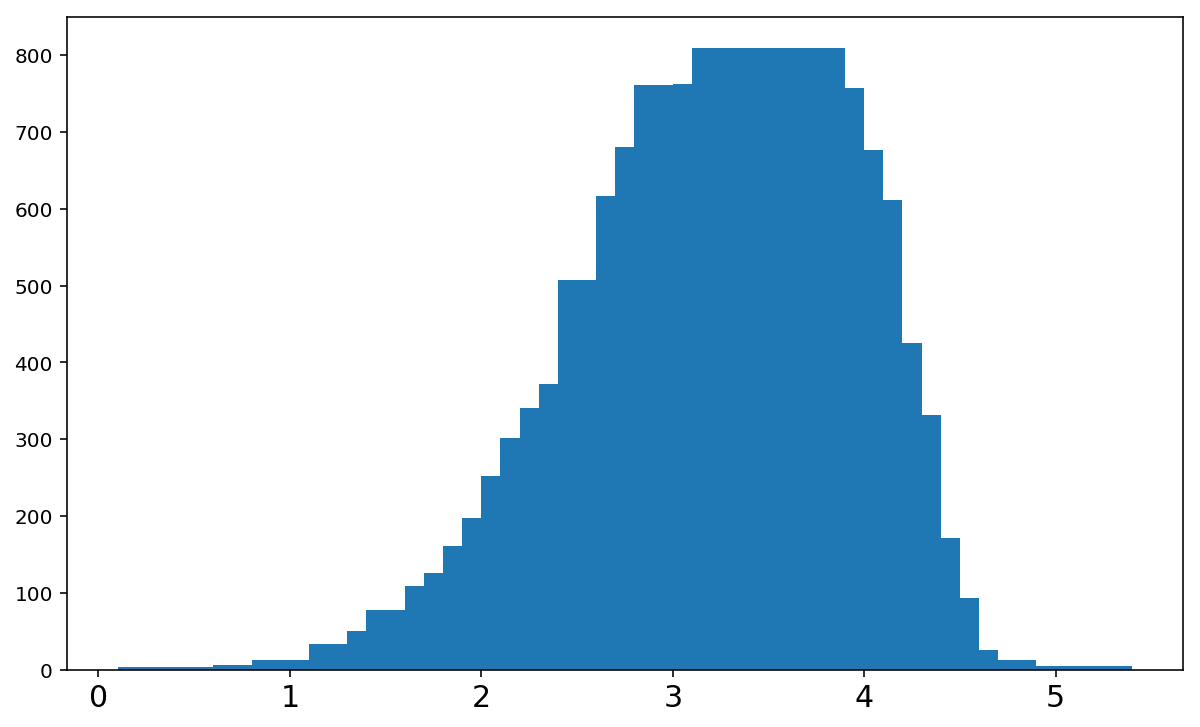

In [64]:
keys, values = zip(*avg_ratings)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [103]:
movie_ratings_count.take(5)

[(2, 12032), (4, 1764), (40966, 208), (8, 899), (51884, 202)]

In [104]:
rating_counts = movie_ratings_count\
    .map(lambda key_value: (key_value[1] // 100, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
rating_counts[:5]

[(0, 4763), (2, 732), (4, 355), (6, 210), (8, 162)]

In [14]:
rating_counts = sorted(rating_counts, key=lambda count: count[1], reverse=True)
rating_counts[:5]

[(0, 4763), (1, 1312), (2, 732), (3, 508), (4, 355)]

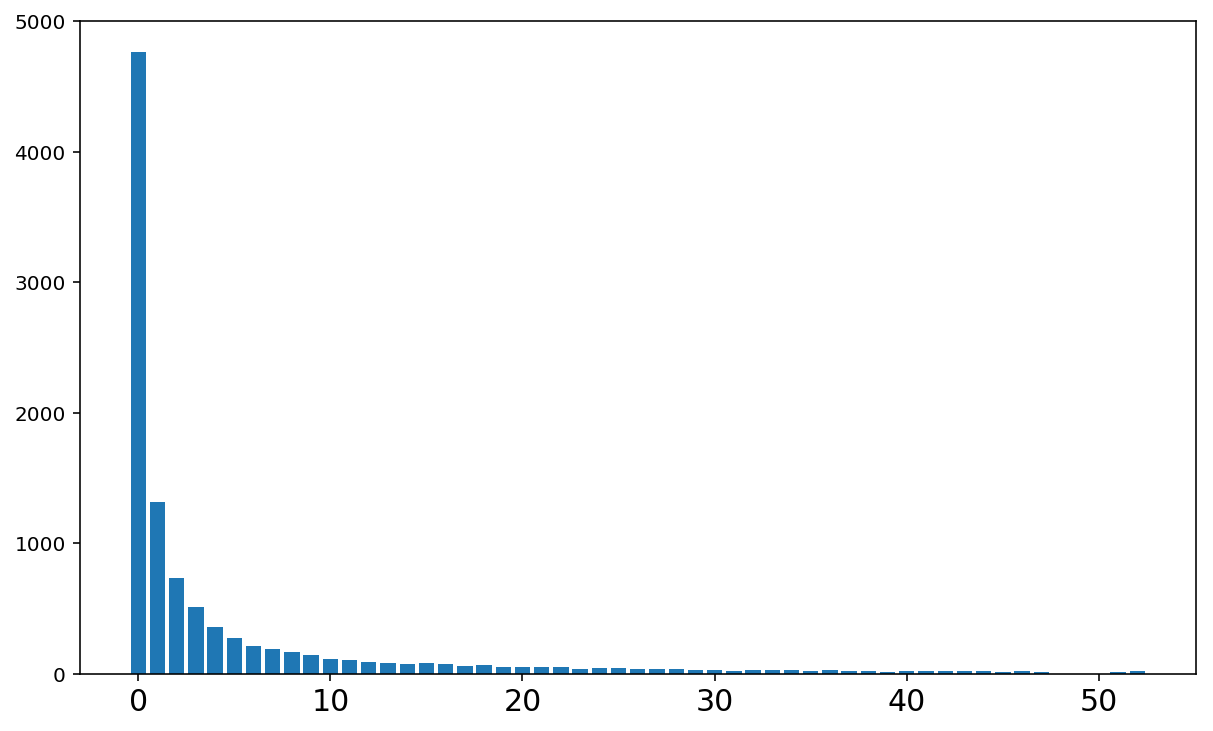

In [15]:
keys, values = zip(*rating_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(keys[:50], values[:50], align="center")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [19]:
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [82]:
genres_counts = movies\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))\
    .flatMap(lambda key_value: key_value[1][-1].split('|'))\
    .map(lambda key_value: (key_value, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()
genres_counts[:5]

[('Sci-Fi', 754),
 ('Horror', 1013),
 ('Drama', 5339),
 ('Action', 1473),
 ('Western', 275)]

In [83]:
genres_counts = sorted(genres_counts, key=lambda count: count[1], reverse=True)
genres_counts[:5]

[('Drama', 5339),
 ('Comedy', 3703),
 ('Thriller', 1706),
 ('Romance', 1685),
 ('Action', 1473)]

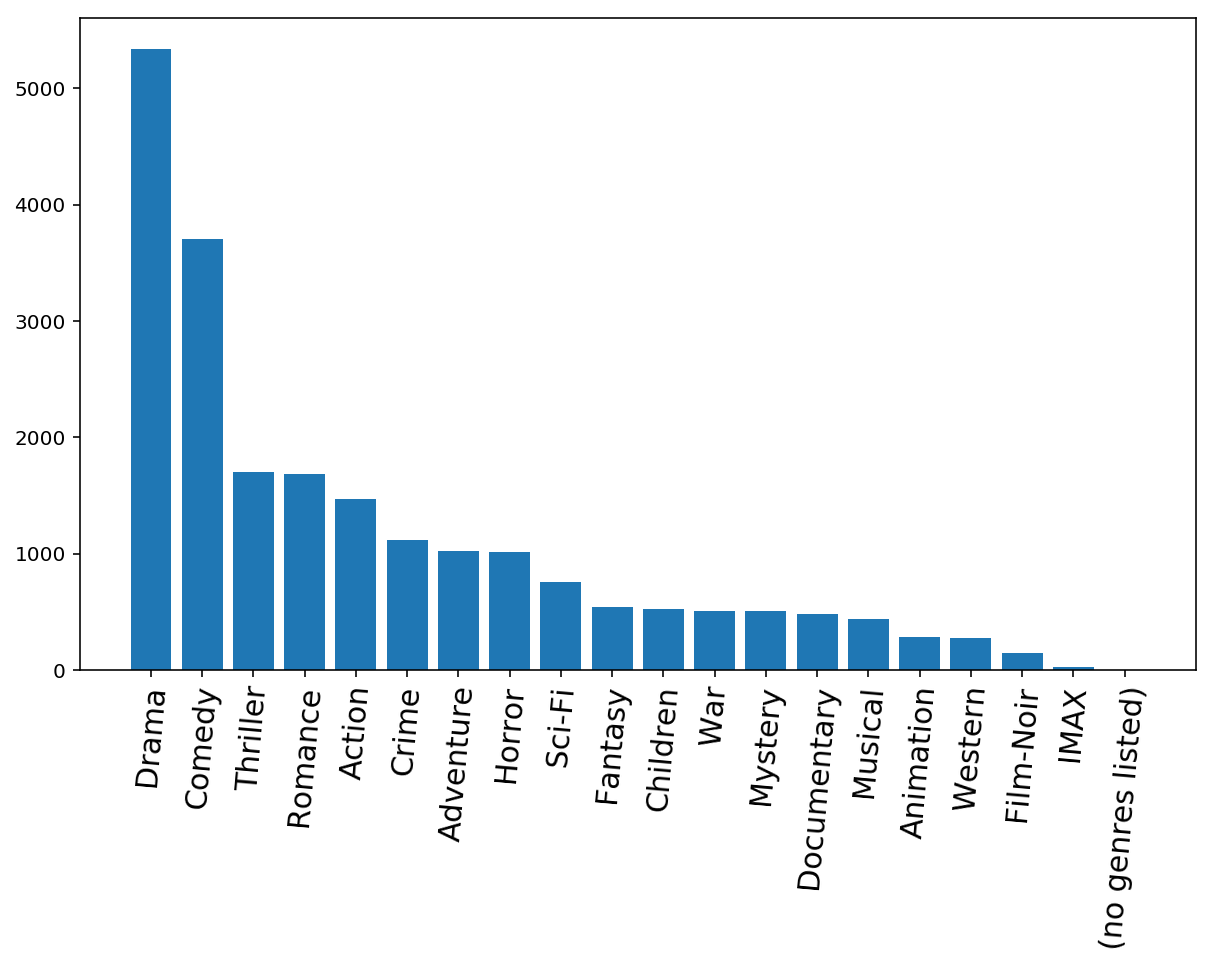

In [85]:
keys, values = zip(*genres_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys[:50], values[:50], align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [20]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
links = sc.textFile(LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [21]:
movies_ids = movies_no_genre\
    .map(lambda key_value: key_value[1][0])\
    .collect()
movies_ids[:5]

['1', '2', '3', '4', '5']

In [22]:
links = links\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit() and arr[0] in movies_ids and arr[-1].isdigit()) \
    .map(lambda arr: (arr[0], int(arr[-1]))) \
    .keyBy(lambda arr: int(arr[0]))
links.take(5)

[(1, ('1', 862)),
 (2, ('2', 8844)),
 (3, ('3', 15602)),
 (4, ('4', 31357)),
 (5, ('5', 11862))]

In [23]:
tmdb_ids = links\
    .map(lambda key_value: key_value[1][1])\
    .collect()
tmdb_ids[:5]

[862, 8844, 15602, 31357, 11862]

In [12]:
tmdb_names = links\
    .join(movies_no_genre)\
    .map(lambda key_value: [key_value[1][0][1], key_value[1][1][1]])\
    .keyBy(lambda arr: arr[0])
tmdb_names.take(5)

[(89992, [89992, 'Curse']),
 (48561, [48561, 'Traviata']),
 (8966, [8966, 'Twilight (2008)']),
 (31357, [31357, 'Waiting to Exhale (1995)']),
 (44708, [44708, 'Blue Gate Crossing (Lanse da Men) (2002)'])]

In [67]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sc.textFile(TMDB_PATH)
tmdb.take(1)

['{"adult": false, "backdrop_path": "/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg", "belongs_to_collection": {"id": 10194, "name": "Toy Story Collection", "poster_path": "/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg", "backdrop_path": "/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg"}, "budget": 30000000, "genres": [{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}], "homepage": "http://toystory.disney.com/toy-story", "id": 862, "imdb_id": "tt0114709", "original_language": "en", "original_title": "Toy Story", "overview": "Led by Woody, Andy\'s toys live happily in his room until Andy\'s birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy\'s heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", "popularity": 25.128, "poster_path": "/rhIRbceoE9lR4veEXuwCC2wARtG.jpg", "production_companies": [{"id": 3, "logo_path": "/1TjvGVDMYsj6JBxOAkUHpPEwLf7.png", 

In [68]:
import json
tmdb = tmdb\
    .map(lambda s: json.loads(s))\
    .filter(lambda rec: rec['id'] in tmdb_ids)\
    .keyBy(lambda rec: rec['id'])
tmdb.take(1)

[(862,
  {'adult': False,
   'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
   'belongs_to_collection': {'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg',
    'id': 10194,
    'name': 'Toy Story Collection',
    'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg'},
   'budget': 30000000,
   'casts': {'cast': [{'cast_id': 14,
      'character': 'Woody (voice)',
      'credit_id': '52fe4284c3a36847f8024f95',
      'gender': 2,
      'id': 31,
      'name': 'Tom Hanks',
      'order': 0,
      'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
     {'cast_id': 15,
      'character': 'Buzz Lightyear (voice)',
      'credit_id': '52fe4284c3a36847f8024f99',
      'gender': 2,
      'id': 12898,
      'name': 'Tim Allen',
      'order': 1,
      'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
     {'cast_id': 16,
      'character': 'Mr. Potato Head (voice)',
      'credit_id': '52fe4284c3a36847f8024f9d',
      'gender': 2,
      'id': 7167,
      'name': 'Don Rickles',
      'or

 Tom Hanks

In [107]:
actors = tmdb\
    .filter(lambda key_value: key_value[0] in tmdb_ids)\
    .flatMapValues(lambda rec: rec['casts']['cast'])\
    .keyBy(lambda arr: int(arr[1]['id']))\
    .mapValues(lambda arr: (arr[0], arr[1]['name']))
actors.take(1)

[(31, (862, 'Tom Hanks'))]

In [71]:
hanks = actors\
    .filter(lambda key_value: key_value[0] == 31)\
    .map(lambda key_value: key_value[1][0])\
    .keyBy(lambda m: m)
hanks.take(5)

[(862, 862), (568, 568), (13, 13), (9800, 9800), (858, 858)]

In [ ]:
hanks\
    .join(tmdb_names)\
    .map(lambda key_value: (key_value[1][1][1]))\
    .collect()

Востребованные актеры

In [111]:
actors\
    .mapValues(lambda arr: (arr[1], 1))\
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1]))\
    .map(lambda key_value: (key_value[1][0], key_value[1][1]))
    .take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 99.0 failed 1 times, most recent failure: Lost task 2.0 in stage 99.0 (TID 148, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-68-34878ab4ef6d>", line 4, in <lambda>
KeyError: 'id'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1843)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor44.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-68-34878ab4ef6d>", line 4, in <lambda>
KeyError: 'id'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [124]:
genres = movies\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: (int(arr[0]), arr[-1].split('|')))\
    .flatMap(lambda arr: map(lambda genre: (arr[0], genre), arr[1]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])
genres.take(5)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy')]

In [142]:
genres_names = genres.map(lambda arr: arr[1]).distinct().collect()
genres_ids = {g:i for i, g in enumerate(genres_names)}
genres_ids

{'(no genres listed)': 14,
 'Action': 3,
 'Adventure': 19,
 'Animation': 17,
 'Children': 5,
 'Comedy': 12,
 'Crime': 15,
 'Documentary': 7,
 'Drama': 2,
 'Fantasy': 9,
 'Film-Noir': 13,
 'Horror': 1,
 'IMAX': 11,
 'Musical': 6,
 'Mystery': 18,
 'Romance': 10,
 'Sci-Fi': 0,
 'Thriller': 8,
 'War': 16,
 'Western': 4}

In [133]:
genres_tmdb = genres\
    .join(links)\
    .map(lambda arr: (arr[1][1][1], arr[1][0]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])
genres_tmdb.take(5)

[(89992, 'Horror'),
 (89992, 'Sci-Fi'),
 (31357, 'Comedy'),
 (31357, 'Drama'),
 (31357, 'Romance')]

In [134]:
years = tmdb\
    .mapValues(lambda rec: rec['release_date'][:4])\
    .join(genres_tmdb)
years.take(5)

KeyboardInterrupt: 

In [ ]:
year_genre_mat = years\
    .map(lambda arr: (arr[1][0], arr[1][1]))\
    .keyBy(lambda arr: (arr[0], arr[1]))\
    .mapValues(lambda arr: 1)\
    .reduceByKey(lambda a, b: a + b)
year_genre_mat.take(5)

In [ ]:
years_sum = year_genre_mat\
    .map(lambda key_value: (key_value[0][0], key_value[1]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])\
    .reduceByKey(lambda a, b: a + b)\
    .collect()
years_sum[:5]
years_sum = {arr[0]:arr[1] for arr in years_sum}
years_ids = {i:arr[0] for i, arr in enumerate(years_sum.keys())}
year_genre_mat = year_genre_mat.collect()
year_genre_mat[:5]

In [ ]:
ratios = [[0.] * len(genres_names) for _ in years_sum]
for arr in year_genre_mat:
    year, genre, s = arr[0][0], arr[0][1], arr[1]
    ratios[genres_ids[genre]][years_ids[year]] = s / years_sum[year]

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(years_sum.keys(), ratios, labels = genres_names)
plt.xticks(sorted(years_sum.keys())[::5], rotation=0, fontsize=15)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################